In [1]:
# will autoupdate any of the packages imported:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.insert(0, '..')
import numpy as np
import matplotlib.pyplot as plt
import pyclifford as pc

In [21]:
from numba import njit
import seaborn as sns
sns.set_theme()
from tqdm import tqdm

In [4]:
def one_layer_brick_wall(circ,even=True):
    for ii in range(int(circ.N//2)):
        if even:
            circ.gate(2*ii,2*ii+1)
        else:
            circ.gate((2*ii+1),(2*ii+2)%circ.N)
    return circ

In [5]:
@njit
def generate_measurement_position(N,p):
    positions = []
    for i in range(N):
        if np.random.rand()<p:
            positions.append(i)
    return positions

In [6]:
def one_layer_measurement(circ,p):
    '''
    Input:
    p (float): measurement probability
    '''
    pos = generate_measurement_position(circ.N,p)
    circ.measure(*pos)
    return circ

In [7]:
def create_circuit(N,depth,p):
    circ = pc.circuit.Circuit(N)
    for i in range(depth):
        circ = one_layer_brick_wall(circ,even=True)
        circ = one_layer_measurement(circ,p)
        circ = one_layer_brick_wall(circ,even=False)
        circ = one_layer_measurement(circ,p)
    return circ

In [8]:
import time

In [34]:
n_qubits = 512
depth = 300
state = pc.zero_state(n_qubits)

circ_even_n = pc.circuit.Circuit(n_qubits)
circ_even_n = one_layer_brick_wall(circ_even_n, even=True)

circ_odd_n = pc.circuit.Circuit(n_qubits)
circ_odd_n = one_layer_brick_wall(circ_odd_n, even=False)

In [35]:
entropies = []
for t in tqdm(range(depth)):
    circ_even_n = pc.circuit.Circuit(n_qubits)
    circ_even_n = one_layer_brick_wall(circ_even_n, even=True)
    circ_even = one_layer_measurement(circ_even_n, 0.1)
    state = circ_even.forward(state)
    entropies.append(state.entropy([i for i in range(n_qubits//2)]))
    
    circ_odd_n = pc.circuit.Circuit(n_qubits)
    circ_odd_n = one_layer_brick_wall(circ_odd_n, even=False)
    circ_odd = one_layer_measurement(circ_odd_n, 0.1)
    state = circ_odd.forward(state)
    entropies.append(state.entropy([i for i in range(n_qubits//2)]))

100%|██████████| 300/300 [01:21<00:00,  3.68it/s]


Text(0, 0.5, '$S_A\\left(p;\\left|A\\right|=\\frac{L}{2},L=512\\right)$')

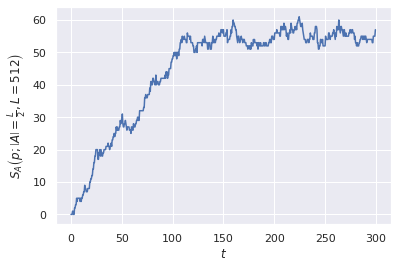

In [36]:
t = np.arange(0, depth, 0.5)
plt.plot(t, entropies)
plt.xlabel(r"$t$")
plt.ylabel(r"$S_A\left(p;\left|A\right|=\frac{L}{2},L=512\right)$")

In [33]:
ctime = time.time()
n_qubits = 512
circ = create_circuit(n_qubits,150,0.1)
state = pc.zero_state(n_qubits)
state = circ.forward(state)
entropy = state.entropy([i for i in range(n_qubits//2)])
print(entropy)
print("time: ",time.time()-ctime)

KeyboardInterrupt: 

In [ ]:
ctime = time.time()
entropy = circ.forward(pc.zero_state(n_qubits)).entropy([i for i in range(n_qubits//2)])
print(entropy)
print("time: ",time.time()-ctime)

# Average half-system entropy

When $p<p_c=0.16$, the system is in the entropy volume-law phase.

In [12]:
ps = np.array([0.1,0.13,0.15,0.17,0.2,0.23])

In [16]:
entropy_mean = np.zeros_like(ps)
entropy_std = np.zeros_like(ps)
for k in range(ps.shape[0]):
    print("measurement prob: ",ps[k])
    entropy_lst = []
    for _ in range(1000):
        circ = create_circuit(300,10,ps[k])
        state = pc.zero_state(300)
        state = circ.forward(state)
        entropy = state.entropy([i for i in range(150)])
        entropy_lst.append(entropy)
    entropy_mean[k] = np.mean(np.array(entropy_lst))
    entropy_std[k] = np.std(np.array(entropy_lst))/np.sqrt(1000)

measurement prob:  0.1


SystemError: CPUDispatcher(<function stabilizer_measure at 0x7f53cd56d0d0>) returned a result with an error set

In [ ]:
plt.errorbar(x = ps,y = entropy_mean,\
             yerr=entropy_std,capsize = 5)
plt.xlabel(r'$P$',fontsize = 14)
plt.ylabel("Half-system entropy",fontsize = 14)
plt.title("10 layers of brickwall circuit",fontsize = 14)